## import necessary packages

In [1]:
import itertools

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## load data

In [11]:
df = pd.read_csv('macro_monthly.csv', index_col=0)
df.index = pd.DatetimeIndex(df.index).to_period('M')

In [12]:
df.columns

Index(['unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs',
       'indpro', 'ccpi'],
      dtype='object')

In [13]:
df.columns = ['Unemployment Rate',
'Personal Saving Rate',
'M2','Disposable Income',
 'Personal Consumption Expenditure',
 'Real Effective Exchange Rate',
 '10Y Treasury Yield',
 'Fed Rate',
 'Construction Spending',
 'Industrial Production Index',
 'Core CPI']

In [18]:
df.shape

(490, 11)

In [21]:
df.head()

,Unemployment Rate,Personal Saving Rate,M2,Disposable Income,Personal Consumption Expenditure,Real Effective Exchange Rate,10Y Treasury Yield,Fed Rate,Construction Spending,Industrial Production Index,Core CPI
DATE,,,,,,,,,,,
1981-01,7.5,10.9,1612.900,4980.4,1870.0,NaN,12.568571,19.084516,NaN,51.1668,85.4
1981-02,7.4,10.8,1608.125,4965.0,1884.2,NaN,13.194444,15.934286,NaN,50.9509,85.9
1981-03,7.4,10.8,1629.400,4979.0,1902.9,NaN,13.115909,14.703871,NaN,51.2066,86.4
1981-04,7.2,10.9,1665.575,4965.1,1904.4,NaN,13.679524,15.719000,NaN,50.9711,87.0
1981-05,7.5,11.0,1655.150,4974.8,1913.8,NaN,14.099500,18.517742,NaN,51.2645,87.8


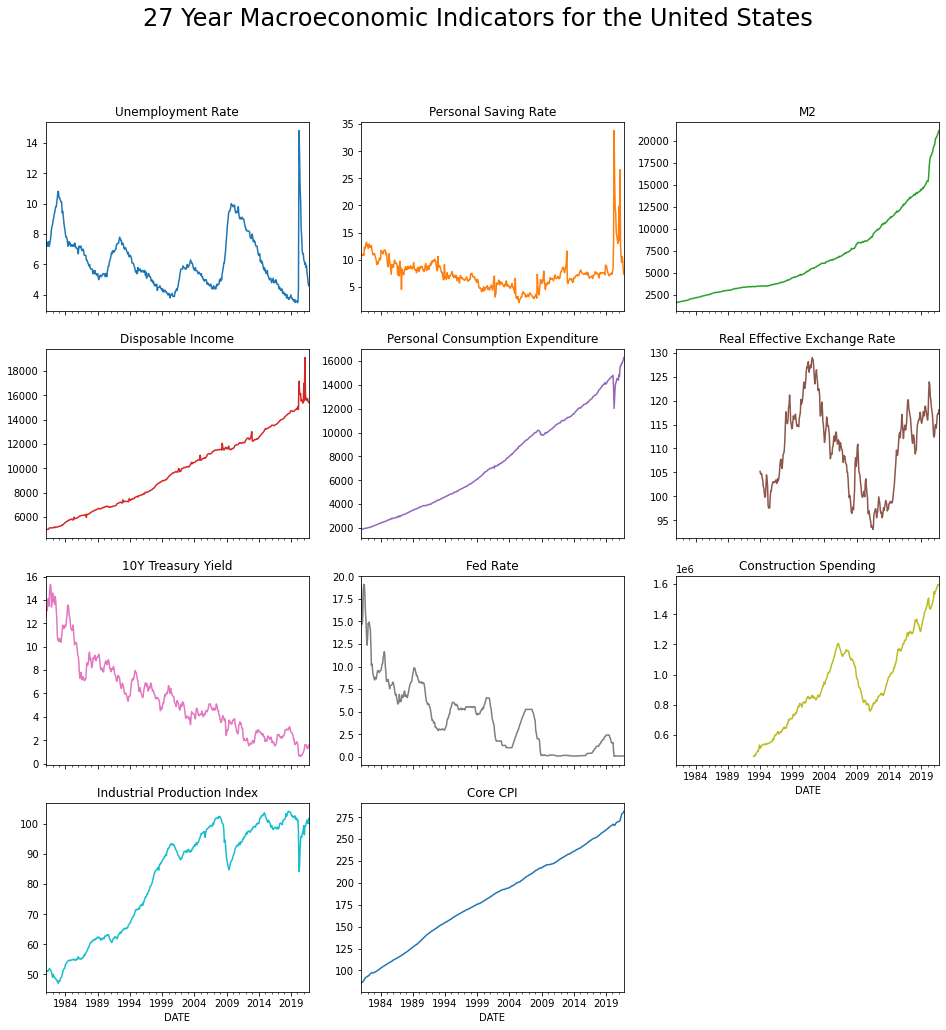

In [15]:
df.plot(subplots = True,
        figsize = (16,16),
        legend = False,
        title = list(df.columns),
        layout = (4,3),
        sharex = True)

plt.suptitle('27 Year Macroeconomic Indicators for the United States', fontsize = 24);

In [22]:
df.columns

Index(['Unemployment Rate', 'Personal Saving Rate', 'M2', 'Disposable Income',
       'Personal Consumption Expenditure', 'Real Effective Exchange Rate',
       '10Y Treasury Yield', 'Fed Rate', 'Construction Spending',
       'Industrial Production Index', 'Core CPI'],
      dtype='object')

In [ ]:
#df = df[['Real Effective Exchange Rate', '10Y Treasury Yield', 'Core CPI']].dropna()
#df.columns = ['Exchange Rate', '10Y Yield', 'CPI']

In [29]:
df_new = df[['10Y Treasury Yield', 'Fed Rate']]
df_new.isna().sum()

10Y Treasury Yield    0
Fed Rate              0
dtype: int64

In [ ]:
#n = len(df)
#train_df = df[0:int(n*0.8)]
#val_df = df[int(n*0.8):int(n*0.9)]
#test_df = df[int(n*0.9):]

# Augmented Dickey–Fuller Stationarity Test

In [25]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [30]:
# ADF Test on each column
for name, column in df_new.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "10Y Treasury Yield" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2311
 No. Lags Chosen       = 3
 Critical value 1%     = -3.444
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.1952. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Fed Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8607
 No. Lags Chosen       = 12
 Critical value 1%     = -3.444
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0501. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [31]:
df_new_stationary = df_new.diff().dropna()

In [32]:
# ADF Test on each column
for name, column in df_new_stationary.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "10Y Treasury Yield" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7993
 No. Lags Chosen       = 13
 Critical value 1%     = -3.444
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Fed Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.5914
 No. Lags Chosen       = 4
 Critical value 1%     = -3.444
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




# Vector Autoregressive (VAR)

In [33]:
model = VAR(df_new_stationary)

In [34]:
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,-5.552,-5.534,0.003881,-5.545
1,-5.893,-5.840*,0.002759,-5.872
2,-5.914,-5.826,0.002702,-5.879
3,-5.933,-5.810,0.002651,-5.885*
4,-5.925,-5.767,0.002672,-5.863
5,-5.914,-5.721,0.002700,-5.838
6,-5.911,-5.683,0.002708,-5.822
7,-5.914,-5.651,0.002702,-5.810
8,-5.944,-5.646,0.002621,-5.827
9,-5.943,-5.609,0.002626,-5.811


In [36]:
model_fitted = model.fit()
lag_order = model_fitted.k_ar

In [37]:
lag_order

1

In [38]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jun, 2024
Time:                     06:51:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.12992
Nobs:                     488.000    HQIC:                  -5.16120
Log likelihood:          -114.613    FPE:                 0.00561992
AIC:                     -5.18144    Det(Omega_mle):      0.00555145
--------------------------------------------------------------------
Results for equation 10Y Treasury Yield
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.017821         0.012268           -1.453           0.146
L1.10Y Treasury Yield         0.284304         0.044622            6.371           0.000
L1.Fed Rate    

## Durbin-Watson

In [41]:
# test for serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_new_stationary.columns, out):
    print(col, ':', round(val, 2))

10Y Treasury Yield : 1.9
Fed Rate : 1.82


## Impulse Response Function

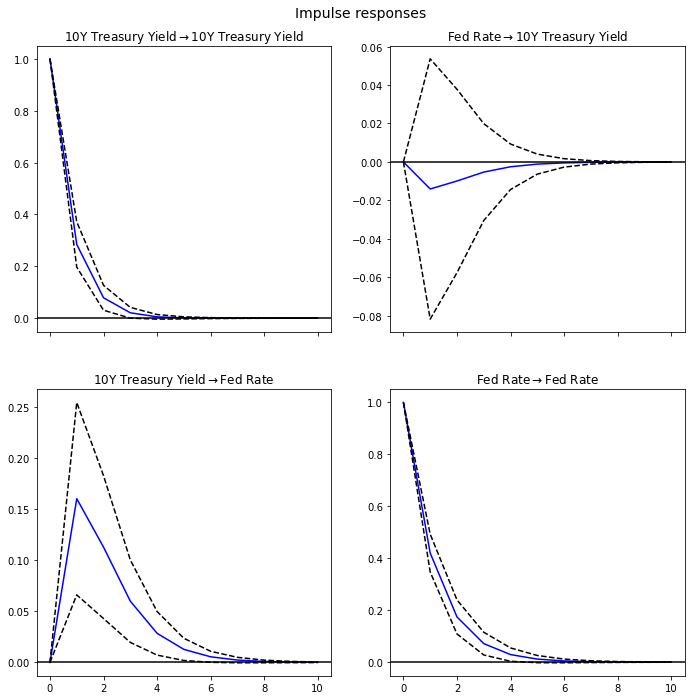

In [42]:
irf = model_fitted.irf(10)
_ = irf.plot(orth=False)

# Granger's Causality

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=8):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
grangers_causation_matrix(train_df_stationary, variables = train_df_stationary.columns)

,Exchange Rate_x,10Y Yield_x,CPI_x
Exchange Rate_y,1.0000,0.0611,0.1283
10Y Yield_y,0.1114,1.0000,0.4469
CPI_y,0.2539,0.4757,1.0000


# Forecasting

## Validation

In [ ]:
val_df_stationary = val_df.diff().dropna()

forecast_window = 1

df_results = pd.DataFrame(columns=train_df_stationary.columns, index=val_df.index)

df_forecast = pd.DataFrame(columns=train_df_stationary.columns, index=val_df.index)

forecast_input = train_df_stationary.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
df_forecast.iloc[0,:] = fc
df_results.iloc[0,:] = train_df.iloc[-1,:].values + fc[0]

for i in range(1,len(val_df)):

    forecast_input = val_df_stationary.values[i-lag_order:i]
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
    df_forecast.iloc[i,:] = fc

    df_results.iloc[i,:] = val_df.iloc[i-1,:] + fc[0]

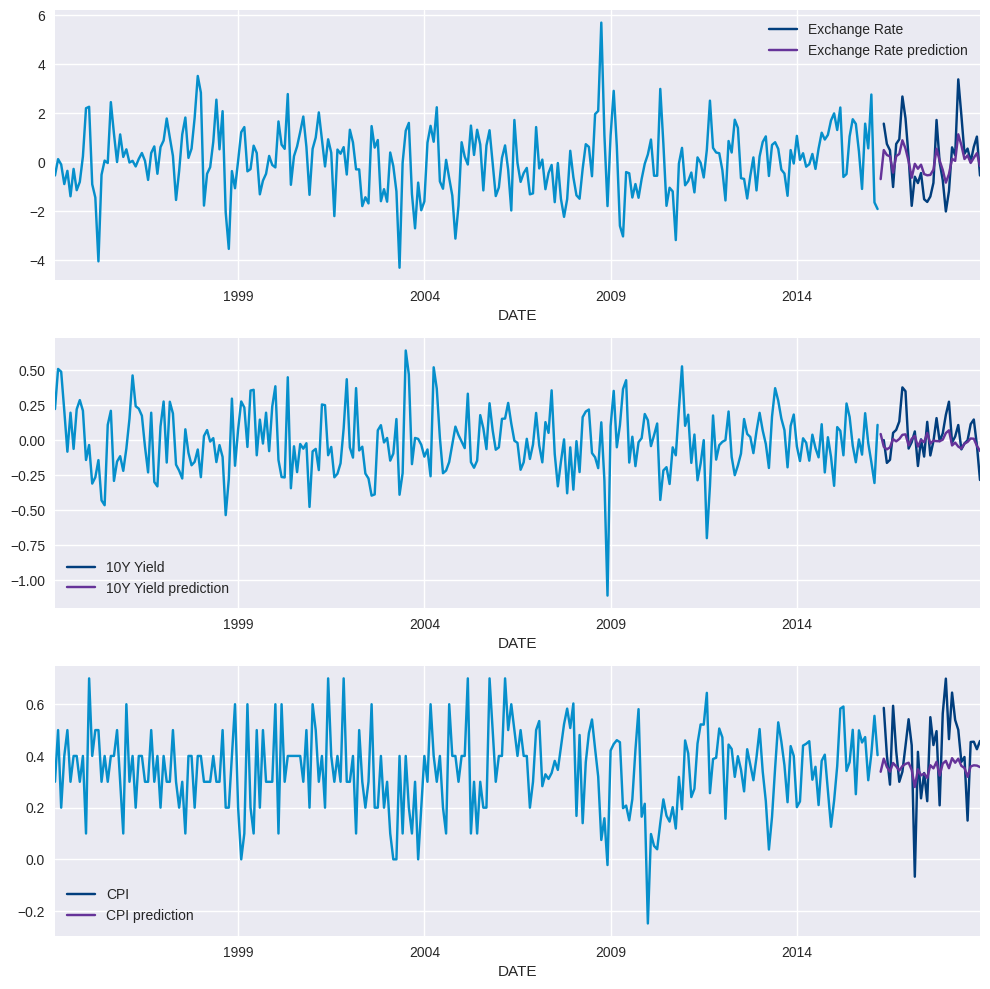

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df_stationary[col].plot(legend=True, ax=ax, color=color_dark_blue);
    train_df_stationary[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_forecast[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

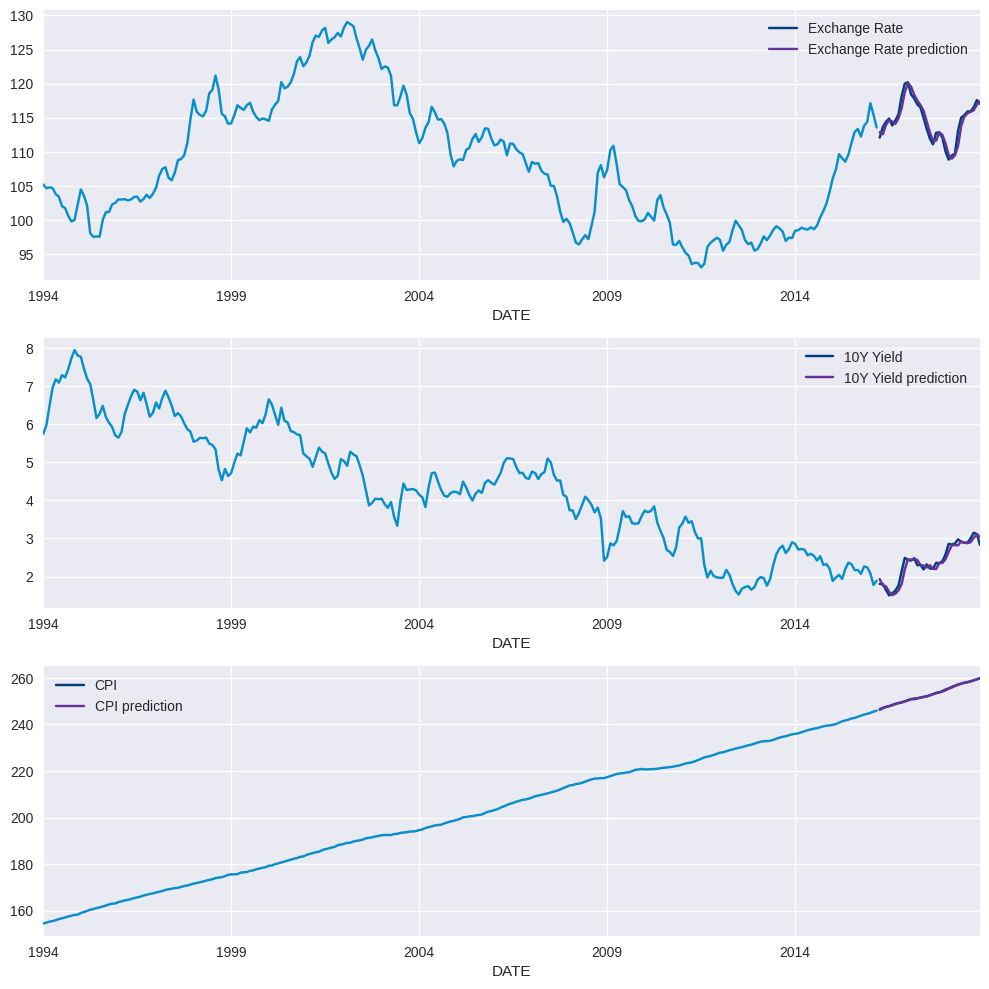

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

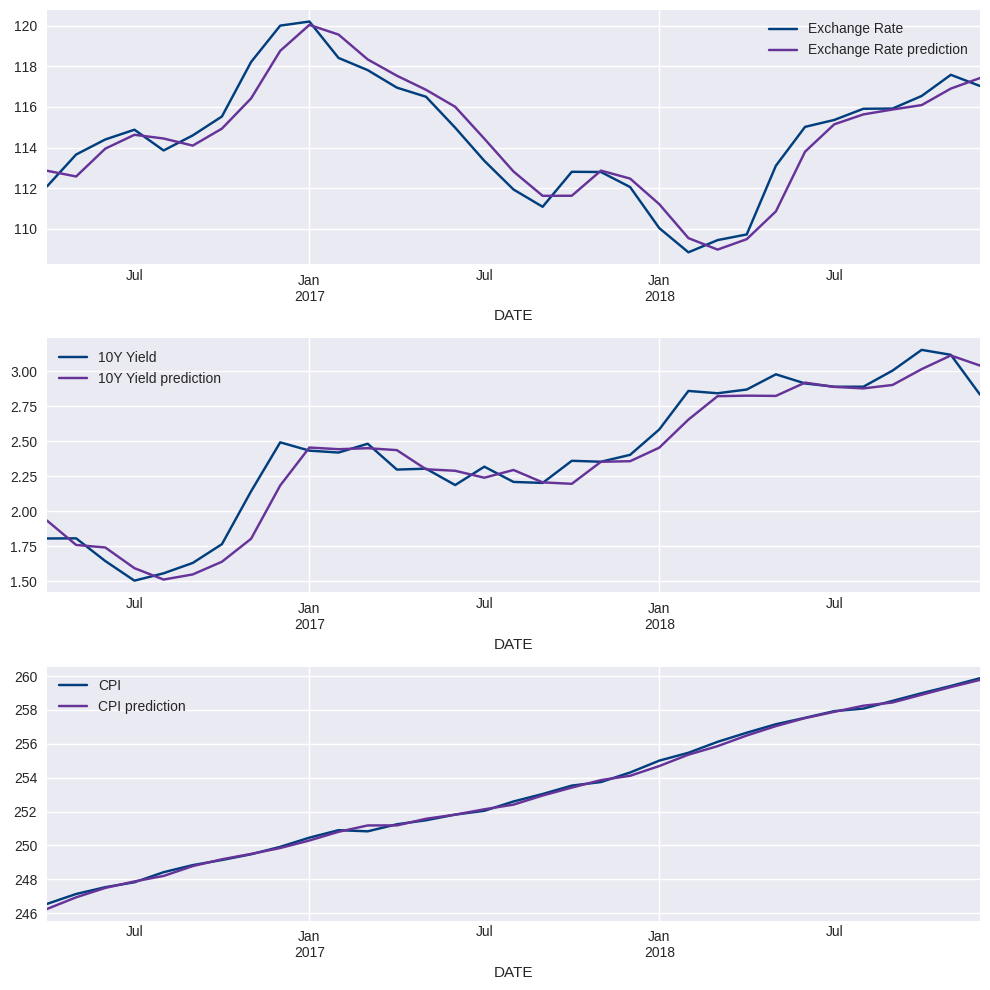

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    #train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

## Test